# Training script

### Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from transformers import AutoTokenizer
from transformers import BertModel
from datasets import load_dataset
from torch import nn
import spacy
import nltk
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_selection import f_classif, SelectKBest
import string
import fasttext
from sklearn.svm import SVC
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

BERT_TOKENIZER = True

if not BERT_TOKENIZER:
    embedder = fasttext.load_model('fasttext/cc.en.300.bin')
    nlp = spacy.load("en_core_web_lg")
else:
    model = BertModel.from_pretrained("bert-base-uncased")
    embedding_matrix = model.embeddings.word_embeddings.weight
    transformer_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

### Models

In [ ]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, num_cells, hidden_size, bi, out_features):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, num_layers = num_cells, hidden_size = hidden_size, bidirectional=bi, batch_first = True)
        self.batch_norm = nn.BatchNorm1d(num_features = hidden_size * 2 if bi else hidden_size)
        self.dropout = nn.Dropout(p = 0.2)
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(in_features = hidden_size * 2 if bi else hidden_size, out_features = out_features)
        #self.relu2 = nn.ReLU()
        #self.linear2 = nn.Linear(in_features = 100, out_features = out_features)
        
        # with torch.no_grad():
            # self.linear1.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
            # self.linear2.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
    
    def forward(self, embedding_sequence):
        # Pad first sequence to max length
        # embedding_sequence[0] = torch.concat([embedding_sequence[0], torch.zeros((self.max_sequence_length - embedding_sequence[0].shape[0] ,self.input_size)).cuda()])
        # Get lenghts vector for every embeddings sequence to later use for packing
        lengths = torch.Tensor([embedding.shape[0] for embedding in embedding_sequence]).long()
        # Pad sequence
        padded_sequence = pad_sequence(embedding_sequence)
        # Pack sequence
        packed_sequence = pack_padded_sequence(padded_sequence, lengths = lengths, enforce_sorted = False)
        # print(padded_sequence.shape)
        
        packed_out, _ = self.lstm(packed_sequence)
        padded_out, _ = pad_packed_sequence(packed_out)
    
        # print(padded_out.shape)
    
        out_forward = padded_out[lengths - 1, range(padded_out.shape[1]), :self.hidden_size]
        out_reverse = padded_out[0, :, self.hidden_size:]
        
        # print(out_forward.shape)
        # print(out_reverse.shape)
        
        out = torch.cat([out_forward, out_reverse], dim = 1)
        
        # print(out.shape)
        
        x = self.batch_norm(out)
        x = self.dropout(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.linear1(x)
        #x = self.relu2(x)
        #x = self.linear2(x)
        return x

In [ ]:
nr_features = 768 if BERT_TOKENIZER else 300
batch_size = 32
learning_rate = 0.0001
epochs = 50
patience = 2
class_weight_beta = 0.9999

TRANSFORMER_MODEL_NAME = 'roberta-base' # ignore this for now

### Loading the dataset

In [ ]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_feature_df(dataset):
    act_types = []
    utterance_list = []
    embedding_list = []
    
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        # print(dataset.loc[i].turns['utterance'])
        # print([frame['service'] for frame in dataset.loc[i].turns['frames']])
        for utterance, speaker, dialogue_act in zip(turns['utterance'], turns['speaker'], turns['dialogue_acts']):
            if speaker == 0: # if it's the user's turn
                if not BERT_TOKENIZER:
                    utterance = utterance.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
                act_type = dialogue_act['dialog_act']['act_type']
                new_utterance = []
                word_embedding_list = []
                
                #### Spacy tokenization + fasttext
                if not BERT_TOKENIZER:
                    doc = nlp(utterance)
                    for token in doc:
                        new_utterance.append(token.lemma_)
                        word_embedding_list.append(embedder.get_word_vector(token.lemma_))
                        embedder
                    embedding = np.stack(word_embedding_list)
                #### Bert embedder
                else:
                    tokenized = transformer_tokenizer(utterance)
                    with torch.no_grad():
                        embedding = embedding_matrix[tokenized.input_ids].detach().numpy()
                ####
                
                # np.mean(word_embedding_list, axis = 0)
                
                new_utterance = ' '.join(new_utterance)
                
                embedding_list.append(embedding)
                act_types.append(process_intent_list(act_type))
                utterance_list.append(new_utterance)
                    
    return utterance_list, embedding_list, act_types

In [ ]:
dataset = load_dataset('multi_woz_v22')

try:
    train
    print("Dataset already loaded, moving on")
except:
    train = preprocess_split(dataset, 'train')
    test = preprocess_split(dataset, 'test')
    val = preprocess_split(dataset, 'validation')
    train_utterance_list, train_embedding_list, train_act_type = extract_feature_df(train)
    test_utterance_list, test_embedding_list, test_act_type = extract_feature_df(test)
    val_utterance_list, val_embedding_list, val_act_type = extract_feature_df(test)

No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (/home/adrian/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 745/745 [00:22<00:00, 32.94it/s]


In [ ]:
mlb = MultiLabelBinarizer().fit(train_act_type)
model = MyLSTM(input_size = nr_features, num_cells = 4, hidden_size = 300, bi = True, out_features = len(mlb.classes_)).cuda()
model.train()

train_labels = mlb.transform(train_act_type)
val_labels = mlb.transform(val_act_type)

In [ ]:
samples_per_class = [0] * len(mlb.classes_)
for act_types in train_act_type:
    for act_type in act_types:
        samples_per_class[np.argmax(mlb.transform([[act_type]]))] += 1

print("Class counts:")
print([*zip(mlb.classes_, samples_per_class)])

samples_per_class = np.array(samples_per_class)

effective_num = 1.0 - np.power(class_weight_beta, samples_per_class)
class_weights = (1.0 - class_weight_beta) / effective_num
class_weights = class_weights / np.sum(class_weights) * len(mlb.classes_)
print("Class weights:")
print([*zip(mlb.classes_, class_weights)])
class_weights = torch.Tensor(class_weights).cuda()

Class counts:
[('Hotel-Inform', 11521), ('Hotel-Request', 2107), ('Restaurant-Inform', 11063), ('Restaurant-Request', 2719), ('general-bye', 2052), ('general-greet', 78), ('general-thank', 5247), ('other', 13894)]
Class weights:
[('Hotel-Inform', 0.07781679375321442), ('Hotel-Request', 0.28017169940200043), ('Restaurant-Inform', 0.07953861567289042), ('Restaurant-Request', 0.22358140714587124), ('general-bye', 0.28691842694505404), ('general-greet', 6.8506983696367305), ('general-thank', 0.1303759509443874), ('other', 0.07089873649985191)]


In [ ]:
def batchify_tokens_tags(embedding_list, labels_list, batch_size):
    embeddings_batch = []
    labels_batch = []
    
    if labels_list is None:
        labels_list = range(len(embedding_list))
    
    for embeddings, label in zip(embedding_list, labels_list):
        embeddings_batch.append(torch.Tensor(embeddings).cuda())
        labels_batch.append(label)
        
        if len(embeddings_batch) == batch_size:
            yield embeddings_batch, torch.Tensor(labels_batch).cuda()
            embeddings_batch.clear()
            labels_batch.clear()
    
    yield embeddings_batch, torch.Tensor(labels_batch).cuda()
    return None

def compute_loss(model, embedding_list, labels_list, batch_size, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for embeddings_batch, labels_batch in batchify_tokens_tags(embedding_list, labels_list, batch_size):
            out = model.forward(embeddings_batch)
            
            loss = criterion(out, labels_batch)
            losses.append(loss.item())
    model.train()
    return np.mean(losses)

/tmp/ipykernel_7438/2586959704.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  yield embeddings_batch, torch.Tensor(labels_batch).cuda()


Epoch 1: Train loss = 0.09272245624539698, Val loss = 0.03682244825305531
Epoch 2: Train loss = 0.03295384650638941, Val loss = 0.02632486456439146
Epoch 3: Train loss = 0.02519657322486561, Val loss = 0.021405596352949
Epoch 4: Train loss = 0.02166349779718228, Val loss = 0.019664503922119984
Epoch 5: Train loss = 0.01978758132012363, Val loss = 0.01953527335468577
Epoch 6: Train loss = 0.018533735174435975, Val loss = 0.019357494958444854
Epoch 7: Train loss = 0.017745214490370836, Val loss = 0.01800608294321358
Epoch 8: Train loss = 0.017017841143676667, Val loss = 0.0170271099874369
Epoch 9: Train loss = 0.016363109737717905, Val loss = 0.017018673203124033
Epoch 10: Train loss = 0.015827872395624703, Val loss = 0.016353308732585354
Epoch 11: Train loss = 0.015377366489030982, Val loss = 0.017076844750846948
Epoch 12: Train loss = 0.015201997834286397, Val loss = 0.016352586998753454
Epoch 13: Train loss = 0.014838089800944459, Val loss = 0.015820029158227517
Epoch 14: Train loss =

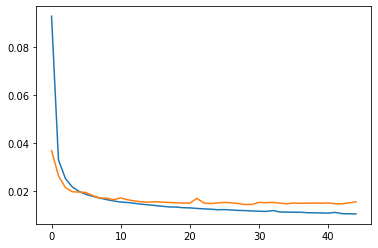

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss(weight = class_weights)
train_losses = []
val_losses = []
waited = 0

for epoch in range(epochs):
    epoch_train_loss = []
    
    for embeddings_batch, labels_batch in batchify_tokens_tags(train_embedding_list, train_labels, batch_size):
        optim.zero_grad()
        out = model.forward(embeddings_batch)
        
        # logits_final, labels_final = outputs_keep_useful_part(out.logits, labels_batch, useful_pos_batch)
        loss = criterion(out, labels_batch)
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_loss)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = compute_loss(model, val_embedding_list, val_labels, batch_size, criterion)
    
    print(f"Epoch {epoch + 1}: Train loss = {epoch_train_loss}, Val loss = {epoch_val_loss}")
    
    if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
        waited += 1
        if waited > patience:
                val_losses.append(epoch_val_loss)
                break
    else:
        waited = 0
    
    val_losses.append(epoch_val_loss)

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()


In [ ]:
def predict(model, embeddings_list, batch_size):
    model.eval()
    predictions = []
    with torch.no_grad():
        for embeddings_batch, _ in batchify_tokens_tags(embeddings_list, None, batch_size):
            out = model.forward(embeddings_batch)
            predictions.append((out > 0.5).cpu().detach().numpy())
    return np.concatenate(predictions)

In [ ]:
test_act_type_pred = predict(model, test_embedding_list, batch_size)

# print(mlb.transform(test_act_type).shape)
# print(test_act_type_pred.shape)

acc = accuracy_score(mlb.transform(test_act_type), test_act_type_pred)
report = classification_report(mlb.transform(test_act_type), test_act_type_pred, target_names = mlb.classes_, digits = 3)
print(report)
print(f'acc = {acc}')

                    precision    recall  f1-score   support

      Hotel-Inform      0.936     0.822     0.875      1328
     Hotel-Request      0.867     0.267     0.408       292
 Restaurant-Inform      0.940     0.815     0.873      1322
Restaurant-Request      0.687     0.322     0.438       286
       general-bye      0.991     0.964     0.977       225
     general-greet      1.000     0.667     0.800         6
     general-thank      0.974     0.965     0.970       693
             other      0.961     0.808     0.878      2039

         micro avg      0.945     0.788     0.859      6191
         macro avg      0.919     0.704     0.777      6191
      weighted avg      0.937     0.788     0.848      6191
       samples avg      0.821     0.808     0.810      6191

acc = 0.7769523151347616


/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
